# Transformer minimalista para classificação de texto

O objetivo é implementar e treinar um modelo transformer simples para classificação de texto no dataset SST2 (https://huggingface.co/datasets/stanfordnlp/sst2)

Primeiramente, você deverá completar o código faltante no Transformer e depois testar melhorias para obter melhor desempenho.

### Instalações e Imports

In [37]:
!pip install datasets

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset   # facilita acesso ao dataset SST2
import numpy as np
from tqdm import tqdm     # barra de progresso


### Tokenizer e carregamento do dataset

In [39]:
class SimpleTokenizer:
    def __init__(self, sentences, max_vocab_size=10000):
        self.vocab = {}
        self.inverse_vocab = {}
        self.special_tokens = {
            '[PAD]': 0,
            '[UNK]': 1,
            '[CLS]': 2,
            '[SEP]': 3
        }

        # Build vocabulary from sentences
        word_counts = Counter()
        for sentence in sentences:
            words = self._tokenize_text(sentence)
            word_counts.update(words)

        # Keep most frequent words
        most_common = word_counts.most_common(max_vocab_size - len(self.special_tokens))

        # Create vocabulary
        for idx, (token, _) in enumerate(most_common, start=len(self.special_tokens)):
            self.vocab[token] = idx
            self.inverse_vocab[idx] = token

        # Add special tokens to vocab
        for token, idx in self.special_tokens.items():
            self.vocab[token] = idx
            self.inverse_vocab[idx] = token

    def _tokenize_text(self, text):
        # Simple whitespace tokenizer with lowercase and basic punctuation splitting
        text = text.lower()
        tokens = []
        word = []
        for char in text:
            if char.isalnum():
                word.append(char)
            else:
                if word:
                    tokens.append(''.join(word))
                    word = []
                if char.strip():  # If it's not whitespace
                    tokens.append(char)
        if word:
            tokens.append(''.join(word))
        return tokens

    def tokenize(self, text):
        return self._tokenize_text(text)

    def convert_tokens_to_ids(self, tokens):
        return [self.vocab.get(token, self.special_tokens['[UNK]']) for token in tokens]

    def encode(self, text, max_length=None, padding=None, truncation=None, return_tensors=None):
        tokens = ['[CLS]'] + self.tokenize(text)

        if truncation and max_length:
            tokens = tokens[:max_length]  # já leva em conta o [CLS]

        input_ids = self.convert_tokens_to_ids(tokens)

        # Handle padding
        if padding == "max_length" and max_length:
            if len(input_ids) < max_length:
                input_ids = input_ids + [self.special_tokens['[PAD]']] * (max_length - len(input_ids))
            elif len(input_ids) > max_length:
                input_ids = input_ids[:max_length]

        # Handle return_tensors
        if return_tensors == "pt":
            return {"input_ids": torch.tensor([input_ids])}
        return {"input_ids": input_ids}

    def __len__(self):
        return len(self.vocab)



#### Encapsulamento do Dataset

In [40]:
class TextClassificationDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.tokenizer.encode(
            text=item["sentence"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Remove batch dimension
            "label": torch.tensor(item["label"])
        }

#### Carregar dataset

In [41]:
dataset = load_dataset("sst2")
train_dataset = dataset["train"].select(range(1000))
val_dataset = dataset["validation"].select(range(200))

# Initialize tokenizer with raw sentences, to avoid circular dependence
train_sentences = [item["sentence"] for item in train_dataset]
tokenizer = SimpleTokenizer(train_sentences, max_vocab_size=5000)
max_length = 64

# Create datasets
train_dataset = TextClassificationDataset(train_dataset, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_dataset, tokenizer, max_length)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


### Componentes do Transformer

#### Encoding posicional

In [42]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_seq_length: int = 512):
        super().__init__()
        position = torch.arange(max_seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_seq_length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]



#### Cabeça de Atenção

**Exercicios:**

1) Preencha o codigo no `__init__` para inicializar as projeções Wq, Wk e Wv. Elas serão projeções lineares (nn.Linear), equivalentes a uma camada de MLP (matriz de pesos e bias).

No forward, elas vão receber a entrada (x) e gerar Q, K e V, respectivamente.

O cuidado que vc precisa ter é com o formato das projeções. Elas vão receber uma entrada com dimensão n x d_model (onde n é o numero de tokens). Elas tem que devolver uma matriz n x d_model.

Um exemplo, se a entrada tem 4 tokens e cada token é representado por um embedding com dimensão 5 (entrada é 4x5), a projeção Wq deve ser `nn.Linear(5,5)`.

Já a escala (que vai dividir o Q x K transposto) é a raiz quadrada de d_model (conforme o artigo do Vaswani et al.)

2) Complete o forward, implementando o cálculo da atenção. Observe que Q, K e V já são gerados usando as projeções que você definiu no `__init__`. Para facilitar o debugging, primeiro calcule:

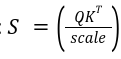

Então aplique o softmax: 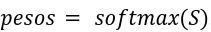

Por fim, calcule e retorne A = pesos x V, que é a saída do módulo de atenção.

**==== Cuidados ====**

Por questões de otimização do loop de treino, a entrada x não é apenas uma matriz (uma frase), mas sim um lote de frases (pense em uma lista de matrizes). Então a primeira dimensão de x é o número de frases (B -- batch size), a segunda é a quantidade de tokens (T) e a terceira é a dimensão do embedding de cada token (C -- alguém achou que C era uma letra legal pra representar isso e acabou pegando...).

Então, Q, K e V terão o mesmo formato de X: B x T x C.

Assim, para gerar K transposto corretamente, use `K.transpose(1,2)` para transpor as dimensões T (1) e C (2).

Para implementar a multiplicação de matrizes Z = A x B, use `Z = A @ B` ou `Z = torch.bmm(A,B)`. Dará o mesmo resultado, mas a segunda é mais otimizada pois já supõe que a A e B tem 3 dimensões. Se os tensores A e B representam 'lotes' de matrizes, Z também representará. Cada item do 'lote' em Z terá o resultado de um item do lote em A multiplicado pelo mesmo item do lote em B.

Além disso, para calcular o softmax corretamente em uma matriz chamada `S`, use `torch.softmax(S, dim=-1)`. Isso o aplicará na dimensão certa (cada linha de cada batch de S).

In [43]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.scale = math.sqrt(d_model)

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        S = torch.bmm(Q, K.transpose(1,2)) / self.scale
        pesos = torch.softmax(S, dim=-1)
        A = torch.bmm(pesos, V)

        return A



##### Teste da inicialização do modulo de atenção

In [44]:
# --- formato das projeções (__init__) ---
d_model = 4
att = SingleHeadAttention(d_model)
assert att.Wq.weight.shape == (4, 4)
assert att.Wk.weight.shape == (4, 4)
assert att.Wv.weight.shape == (4, 4)
assert att.scale == 2
print("✅ Formato das projeções e escala do modulo de atenção corretos.")


✅ Formato das projeções e escala do modulo de atenção corretos.


##### Teste do cálculo de atenção

Note que a entrada e a saída esperada são tensores 3d, com formato B x T x C = 1 x 2 x 2 (lote de 1 frase, com 2 tokens de dimensão 2).

In [45]:
d_model = 2
att = SingleHeadAttention(d_model)

# Configura projecoes customizadas pra dar o resultado pré-definido
att.Wq.weight.data = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
att.Wq.bias.data.zero_()

att.Wk.weight.data = torch.tensor([[0.5, -1.0], [1.5, 2.0]])
att.Wk.bias.data.zero_()

att.Wv.weight.data = torch.tensor([[2.0, 0.0], [0.0, 1.0]])
att.Wv.bias.data.zero_()

# Define input x: (batch_size B=1, seq_len T=2, d_model C=2)
x = torch.tensor([[
    [1.0, 0.0],   # token 1
    [0.0, 1.0]    # token 2
]])


# Run model
output = att(x)

# previously-known expected output
expected_output = torch.tensor([[
    [1.000000, 0.500000], #contextual embedding of token 1
    [1.339523, 0.330238]  #contextual embedding of token 2
]])

torch.set_printoptions(precision=6)

# Compare
assert torch.allclose(output, expected_output, atol=1e-5), f"Expected {expected_output}, got {output}"
print("✅ Teste do calculo da atenção aprovado")

✅ Teste do calculo da atenção aprovado


#### MLP

In [46]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout1(self.relu(self.linear1(x)))
        x = self.dropout2(self.linear2(x))
        return x



#### Bloco Transformer

Executa a atenção seguida do MLP. Há conexões residuais (saltos) da entrada pra saída da atenção e dela pra saída do MLP.

In [47]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.attention = SingleHeadAttention(d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attention_output = self.attention(x)
        x = self.norm1(x + self.dropout(attention_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x



#### Transformer para classificação de texto

O forward processa a entrada pra gerar a saída.

A entrada (vetor de tokens) passa pelo token embedding (gerando a matriz (tokens x dimensões), encoding posicional, dropout e bloco transformer. Ao final, o embedding do token especial [CLS] é usado para classificação (sem softmax). O tokenizador anexa este token ao início de qualquer texto. Antes disso, usava-se um pooling (max ou mean) de cada embedding da sequência de tokens para gerar o embedding final que representasse toda a sequência.

Este transformer não tem as conexões residuais e LayerNorm (é mais simples que o definido em Vaswani(2017).

In [48]:
# TODO testar mais blocos transformer (a saida de um bloco entra no seguinte)
class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 256,  # dimensao dos embeddings
        n_classes: int = 2,
        max_seq_length: int = 64,
        d_ff: int = 1024,    # num. de neuronios na camada nos MLP do transformer
        dropout: float = 0.3,
        num_blocks=2
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length)
        # self.dropout = nn.Dropout(dropout)

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(d_model, d_ff, dropout) for _ in range(num_blocks)]
        )



        # classificador final (nao usa o d_ff, apenas o MLP do transformer usa)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, n_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        # x = self.dropout(x)

        x = self.transformer_blocks(x)       # pode sequenciar mais de um

        cls_output = x[:, 0, :]        # Extract [CLS] token embedding (position 0)
        return self.classifier(cls_output)




### Training loop

In [49]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight decay

    best_val_acc = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Train]')
        for batch in train_pbar:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            # Gradient clipping (estabiliza o treinamento)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loss += loss.item()

            train_pbar.set_postfix({
                'loss': f'{train_loss/(train_pbar.n+1):.4f}',
                'acc': f'{100*train_correct/train_total:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Val]')
            for batch in val_pbar:
                input_ids = batch["input_ids"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item()

                val_pbar.set_postfix({
                    'loss': f'{val_loss/(val_pbar.n+1):.4f}',
                    'acc': f'{100*val_correct/val_total:.2f}%'
                })

        val_acc = 100 * val_correct / val_total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with val acc: {val_acc:.2f}%')

        print(f'\nEpoch {epoch + 1}/{num_epochs}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f} | Acc: {100*train_correct/train_total:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f} | Acc: {val_acc:.2f}%')
        print('-' * 60)

### Instanciar e treinar modelo

In [50]:
# Initialize and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TransformerClassifier(
    vocab_size=len(tokenizer),
    d_model=64,   # testar outros valores aqui
    n_classes=2,
    max_seq_length=max_length,
    d_ff=64,      # testar outros valores aqui
    dropout=0,     # testar outros valores aqui
    num_blocks=2  # testar outros valores aqui
).to(device)

# Train the model
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5,
    learning_rate=0.0001,
    device=device
)

Using device: cpu


Epoch 1/5 [Val]: 100%|██████████| 7/7 [00:00<00:00, 22.77it/s, loss=0.6917, acc=49.50%]


New best model saved with val acc: 49.50%

Epoch 1/5:
Train Loss: 0.6925 | Acc: 53.40%
Val Loss: 0.6917 | Acc: 49.50%
------------------------------------------------------------


Epoch 2/5 [Val]: 100%|██████████| 7/7 [00:00<00:00, 28.98it/s, loss=1.2105, acc=49.50%]



Epoch 2/5:
Train Loss: 0.6904 | Acc: 54.20%
Val Loss: 0.6917 | Acc: 49.50%
------------------------------------------------------------


Epoch 3/5 [Val]: 100%|██████████| 7/7 [00:00<00:00,  7.98it/s, loss=0.6914, acc=49.50%]



Epoch 3/5:
Train Loss: 0.6899 | Acc: 54.20%
Val Loss: 0.6914 | Acc: 49.50%
------------------------------------------------------------


Epoch 4/5 [Val]: 100%|██████████| 7/7 [00:00<00:00, 20.74it/s, loss=0.6917, acc=49.50%]



Epoch 4/5:
Train Loss: 0.6905 | Acc: 54.20%
Val Loss: 0.6917 | Acc: 49.50%
------------------------------------------------------------


Epoch 5/5 [Val]: 100%|██████████| 7/7 [00:00<00:00, 52.72it/s, loss=0.8072, acc=49.50%]


Epoch 5/5:
Train Loss: 0.6901 | Acc: 54.30%
Val Loss: 0.6919 | Acc: 49.50%
------------------------------------------------------------


### Inferência pós-treino

In [51]:
# Example inference
def predict_sentiment(model, tokenizer, text, device):
    model.eval()
    encoding = tokenizer.encode(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)

    with torch.no_grad():
        outputs = model(input_ids)
        predictions = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(predictions, dim=1)
        confidence = predictions[0][predicted_class].item()

    sentiment = "Positive" if predicted_class.item() == 1 else "Negative"
    return sentiment, confidence

# Test the model with a sample sentence
sample_text = "This movie was really enjoyable and well-made!"
sentiment, confidence = predict_sentiment(model, tokenizer, sample_text, device)
print(f"\nText: {sample_text}")
print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2f})")


Text: This movie was really enjoyable and well-made!
Predicted sentiment: Positive (confidence: 0.54)


## Melhorias

Note que o modelo treina rápido, mas o desempenho é muito ruim: mesmo no treino, não consegue se distanciar de um palpite aleatório. Mude as configurações do modelo (dimensões do embedding (d_model), dimensões do MLP (d_ff), dropout, sequenciar mais blocos Transformer, etc.) e de treino (num. épocas, learning rate, etc.) para chegar num desempenho melhor.

É possível chegar a uma acurácia de treino/teste de 80%/60%, mas não se estresse se não conseguir chegar nesses valores. Faça o seu melhor!

In [52]:
# Initialize and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TransformerClassifier(
    vocab_size=len(tokenizer),
    d_model=128,   # testar outros valores aqui
    n_classes=2,
    max_seq_length=max_length,
    d_ff=256,      # testar outros valores aqui
    dropout=0.1,     # testar outros valores aqui
    num_blocks=4  # testar outros valores aqui
).to(device)

# Train the model
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    learning_rate=0.0005,
    device=device
)

Using device: cpu


Epoch 1/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 16.02it/s, loss=0.6915, acc=49.50%]


New best model saved with val acc: 49.50%

Epoch 1/10:
Train Loss: 0.6980 | Acc: 51.30%
Val Loss: 0.6915 | Acc: 49.50%
------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 15.84it/s, loss=0.6902, acc=49.50%]



Epoch 2/10:
Train Loss: 0.6916 | Acc: 53.80%
Val Loss: 0.6902 | Acc: 49.50%
------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 16.22it/s, loss=0.6932, acc=49.50%]



Epoch 3/10:
Train Loss: 0.6973 | Acc: 52.40%
Val Loss: 0.6932 | Acc: 49.50%
------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 16.51it/s, loss=0.6638, acc=59.00%]


New best model saved with val acc: 59.00%

Epoch 4/10:
Train Loss: 0.6842 | Acc: 55.30%
Val Loss: 0.6638 | Acc: 59.00%
------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.36it/s, loss=0.6485, acc=62.50%]


New best model saved with val acc: 62.50%

Epoch 5/10:
Train Loss: 0.6376 | Acc: 63.00%
Val Loss: 0.6485 | Acc: 62.50%
------------------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 16.50it/s, loss=0.6688, acc=65.00%]


New best model saved with val acc: 65.00%

Epoch 6/10:
Train Loss: 0.5357 | Acc: 74.00%
Val Loss: 0.6688 | Acc: 65.00%
------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 10.63it/s, loss=0.7485, acc=61.00%]



Epoch 7/10:
Train Loss: 0.4016 | Acc: 83.10%
Val Loss: 0.7485 | Acc: 61.00%
------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 16.66it/s, loss=0.9440, acc=60.50%]



Epoch 8/10:
Train Loss: 0.2788 | Acc: 89.20%
Val Loss: 0.9440 | Acc: 60.50%
------------------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 10.52it/s, loss=1.2189, acc=61.50%]



Epoch 9/10:
Train Loss: 0.1782 | Acc: 93.00%
Val Loss: 1.2189 | Acc: 61.50%
------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 15.48it/s, loss=1.5358, acc=57.00%]


Epoch 10/10:
Train Loss: 0.1223 | Acc: 95.80%
Val Loss: 1.5358 | Acc: 57.00%
------------------------------------------------------------


In [53]:
# Example inference
def predict_sentiment(model, tokenizer, text, device):
    model.eval()
    encoding = tokenizer.encode(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)

    with torch.no_grad():
        outputs = model(input_ids)
        predictions = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(predictions, dim=1)
        confidence = predictions[0][predicted_class].item()

    sentiment = "Positive" if predicted_class.item() == 1 else "Negative"
    return sentiment, confidence

# Test the model with a sample sentence
sample_text = "This movie was really enjoyable and well-made!"
sentiment, confidence = predict_sentiment(model, tokenizer, sample_text, device)
print(f"\nText: {sample_text}")
print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2f})")


Text: This movie was really enjoyable and well-made!
Predicted sentiment: Positive (confidence: 0.98)
